In [1]:
import sys
print(sys.version)

CURR_DIR = '/content/drive/My Drive/google_colab_work/detailed_deep_learning/'
sys.path.append(CURR_DIR)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat import v1 as tf_v1
print(tf.version)
tf.compat.v1.disable_eager_execution()
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [3]:
np.random.seed(0)
tf.random.set_seed(1234)

In [4]:
def Inference(x_ph, batch_size_ph, max_t, n_hidden, n_out):
    lstm_cell = tf_v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    init_hidden_sate = lstm_cell.zero_state(batch_size_ph, tf.float32)

    hidden_sate = init_hidden_sate
    hiddens = []
    with tf_v1.variable_scope('LSTM'):
        for t in range(max_t):
            if 0 < t:
                tf_v1.get_variable_scope().reuse_variables()

            lstm_cell_output, hidden_sate = lstm_cell(x_ph[:, t, :], hidden_sate)
            hiddens.append(lstm_cell_output)

    latest_hidden = hiddens[-1]
    
    W_out = tf.Variable(tf.random.truncated_normal([n_hidden, n_out], stddev=0.01))
    b_out = tf.Variable(tf.zeros([n_out], dtype=tf.float32))
    y = tf.matmul(latest_hidden, W_out) + b_out
    return y


def Loss(y, t_ph):
    mse = tf.reduce_mean(tf.square(y - t_ph))
    return mse


def Training(loss):
    optimizer = tf_v1.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step

In [5]:
def Mask(max_t):
    mask = np.zeros(max_t)
    indices = np.random.permutation(np.arange(max_t))[:2]
    mask[indices] = 1
    return mask


def AddingProblem(n_data, max_t):
    signals = np.random.uniform(low=0.0, high=1.0, size=(n_data, max_t))
    masks = np.zeros((n_data, max_t))
    for i in range(n_data):
        masks[i] = Mask(max_t)

    data = np.zeros((n_data, max_t, 2))
    data[:, :, 0] = signals
    data[:, :, 1] = masks
    target = (signals*masks).sum(axis=1).reshape(n_data, 1)

    return data, target

In [6]:
n_data = 10000
max_t = 200

X, T = AddingProblem(n_data, max_t)
print('X.shape =', X.shape)
print()

n_train = int(round(0.9 * n_data))
n_valid = n_data - n_train
X_train, X_valid, T_train, T_valid = sklearn.model_selection.train_test_split(X, T, test_size=n_valid)
print('X_train.shape =', X_train.shape, ', X_valid.shape =', X_valid.shape)
print()

X.shape = (10000, 200, 2)

X_train.shape = (9000, 200, 2) , X_valid.shape = (1000, 200, 2)



In [7]:
n_in = len(X[0][0])
n_hidden = 100
n_out = len(T[0])

x_ph = tf_v1.placeholder(tf.float32, shape=[None, max_t, n_in])
batch_size_ph = tf_v1.placeholder(tf.int32, shape=[])
t_ph = tf_v1.placeholder(tf.float32, shape=[None, n_out])

y = Inference(x_ph, batch_size_ph, max_t, n_hidden, n_out)
loss = Loss(y, t_ph)
train_step = Training(loss)

history = {
    'valid_loss': [],
}

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
epochs = 200
batch_size = 100
n_batches = n_train // batch_size

init = tf_v1.global_variables_initializer()
sess = tf_v1.Session()
sess.run(init)

for epoch in range(epochs):
    X_shuffle, T_shuffle = sklearn.utils.shuffle(X_train, T_train)

    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size

        sess.run(train_step, feed_dict={
            x_ph: X_shuffle[start:end],
            t_ph: T_shuffle[start:end],
            batch_size_ph: batch_size
        })

    valid_loss = loss.eval(session=sess, feed_dict={
        x_ph: X_valid,
        t_ph: T_valid,
        batch_size_ph: n_valid
    })

    history['valid_loss'].append(valid_loss)
    if epoch % 10 == 0:
        print('epoch =', epoch, ', valid_loss =', valid_loss)

epoch = 0 , valid_loss = 0.17248417
epoch = 10 , valid_loss = 0.17260166
epoch = 20 , valid_loss = 0.17327218
epoch = 30 , valid_loss = 0.17385586
epoch = 40 , valid_loss = 0.17227603
epoch = 50 , valid_loss = 0.17294341
epoch = 60 , valid_loss = 0.17371893
epoch = 70 , valid_loss = 0.17235287
epoch = 80 , valid_loss = 0.17249484
epoch = 90 , valid_loss = 0.17228669
epoch = 100 , valid_loss = 0.17239301
epoch = 110 , valid_loss = 0.1720817
epoch = 120 , valid_loss = 0.1726533
epoch = 130 , valid_loss = 0.17316933
epoch = 140 , valid_loss = 0.1731882
epoch = 150 , valid_loss = 0.17237967
epoch = 160 , valid_loss = 0.17161106
epoch = 170 , valid_loss = 0.17293319
epoch = 180 , valid_loss = 0.020691631
epoch = 190 , valid_loss = 0.0035345687


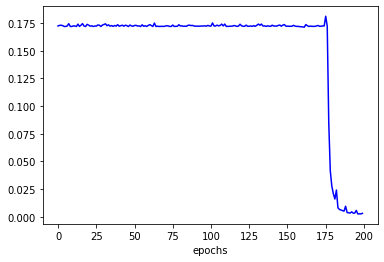

In [9]:
fig = plt.figure()
ax_loss = fig.add_subplot(1,1,1)
ax_loss.plot(range(epochs), history['valid_loss'], label='valid_loss', color='blue')
plt.xlabel('epochs')
plt.show()